In [1]:
import optuna
from optuna.samplers import TPESampler
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
#from joblib import dump

In [2]:
# CUDA
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE.type

'cuda'

In [3]:
# Fix random seed
seed = 42
torch.manual_seed(seed)
if DEVICE.type == 'cuda':
	torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Pre-processing input data

In [5]:
def bits_to_MiB(row):
	# verify if has string ' MiB'
	if 'MiB' in str(row):
		row = row.replace(' MiB', '')
		row = float(row)
	else:
		row = float(row) / np.power(2, 20)
	return row


def MHz_to_GHz(row):
	# verify if has string ' GHz'
	if 'GHz' in str(row):
		row = row.replace(' GHz', '')
		# convert to float
		row = float(row)
	else:
		row = row.replace(' MHz', '')
		row = float(row) / 1000
	return row

In [6]:
results_df = pd.read_csv('../results_new/execution_time.csv')
results_savio_df = pd.read_csv('../results_savio_new/execution_time.csv')
results_df = pd.concat([results_df, results_savio_df], ignore_index=True)
# preprocessing
results_df['total_cpu_usage'] = results_df['total_cpu_usage'].str.replace('%', '').astype(float) / 100
results_df['max_ram_usage'] = results_df['max_ram_usage'] / 1024
results_df['l2_cache_size'] = results_df['l2_cache_size'].apply(bits_to_MiB)
results_df['l3_cache_size'] = results_df['l3_cache_size'].apply(bits_to_MiB)
results_df['ghz_actual_friendly'] = results_df['hz_actual_friendly'].apply(MHz_to_GHz)
results_df['ghz_advertised_friendly'] = results_df['hz_advertised_friendly'].str.replace('GHz', '').astype(float)
results_df = results_df.drop(columns=['hz_actual_friendly', 'hz_advertised_friendly', 'arch', 'vendor_id_raw'])

In [7]:
# Make the target dataset
target_df = results_df[['total_time', 'brand_raw', 'count', 'l2_cache_size', 'l3_cache_size', 'l2_cache_line_size', 'l2_cache_associativity', 'ghz_advertised_friendly', 'benchmark']].copy()
# Rename columns to *_target
target_df = target_df.rename(columns={
    'total_time': 'total_time_target',
    'brand_raw': 'brand_raw_target',
    'count': 'count_target',
    'l2_cache_size': 'l2_cache_size_target',
    'l3_cache_size': 'l3_cache_size_target',
    'l2_cache_line_size': 'l2_cache_line_size_target',
    'l2_cache_associativity': 'l2_cache_associativity_target',
    'ghz_advertised_friendly': 'ghz_advertised_friendly_target',
})

dataset_df = pd.merge(results_df, target_df, how='inner', on='benchmark')
dataset_df = dataset_df[dataset_df['brand_raw'] != dataset_df['brand_raw_target']]
dataset_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,count,l2_cache_size,l3_cache_size,l2_cache_line_size,l2_cache_associativity,benchmark,ghz_actual_friendly,ghz_advertised_friendly,total_time_target,brand_raw_target,count_target,l2_cache_size_target,l3_cache_size_target,l2_cache_line_size_target,l2_cache_associativity_target,ghz_advertised_friendly_target
5,13.47,0.99,1436.714844,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,12,1.5,12.0,256,6,KNP,4.1729,2.9,45.91,13th Gen Intel(R) Core(TM) i5-1335U,12,7.5,12.0,1280,7,2.496
6,13.47,0.99,1436.714844,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,12,1.5,12.0,256,6,KNP,4.1729,2.9,25.77,13th Gen Intel(R) Core(TM) i5-1335U,12,7.5,12.0,1280,7,2.496


In [8]:
# remove one computer for testing
g_train = dataset_df[(dataset_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (dataset_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
g_test = dataset_df[dataset_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [9]:
mm_df = dataset_df[dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]
# remove one computer for testing
mm_train = mm_df[(mm_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (mm_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
mm_test = mm_df[mm_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [10]:
st_df = dataset_df[~dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]
# remove one computer for testing
st_train = st_df[(st_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (st_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
st_test = st_df[st_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [11]:
# load test dataset
# g_test = pd.read_csv('csv/g_test.csv')
# st_test = pd.read_csv('csv/st_test.csv')
# mm_test = pd.read_csv('csv/mm_test.csv')

In [12]:
target = 'total_time_target'
features = mm_test.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target'])
features_st = features.copy().drop(['count', 'count_target'])

In [13]:
# general data
## split data
X_g_train = g_train[features]
y_g_train = g_train[target]

X_g_test = g_test[features]
y_g_test = g_test[target]

## normalize data
x_g_scaler = MinMaxScaler(feature_range=(0, 1))
X_g_train = x_g_scaler.fit_transform(X_g_train)
X_g_test = x_g_scaler.transform(X_g_test)
y_g_scaler = MinMaxScaler(feature_range=(0, 1))
y_g_train = y_g_scaler.fit_transform(y_g_train.values.reshape(-1, 1))
y_g_test = y_g_scaler.transform(y_g_test.values.reshape(-1, 1))

## convert to tensor
X_g_train = torch.tensor(X_g_train, dtype=torch.float32).unsqueeze(1)
X_g_test = torch.tensor(X_g_test, dtype=torch.float32).unsqueeze(1)
y_g_train = torch.tensor(y_g_train, dtype=torch.float32)
y_g_test = torch.tensor(y_g_test, dtype=torch.float32)

In [14]:
# single thread data
## split data
X_st_train = st_train[features_st]
y_st_train = st_train[target]

X_st_test = st_test[features_st]
y_st_test = st_test[target]

## normalize data
x_st_scaler = MinMaxScaler(feature_range=(0, 1))
X_st_train = x_st_scaler.fit_transform(X_st_train)
X_st_test = x_st_scaler.transform(X_st_test)
y_st_scaler = MinMaxScaler(feature_range=(0, 1))
y_st_train = y_st_scaler.fit_transform(y_st_train.values.reshape(-1, 1))
y_st_test = y_st_scaler.transform(y_st_test.values.reshape(-1, 1))

## convert to tensor
X_st_train = torch.tensor(X_st_train, dtype=torch.float32).unsqueeze(1)
X_st_test = torch.tensor(X_st_test, dtype=torch.float32).unsqueeze(1)
y_st_train = torch.tensor(y_st_train, dtype=torch.float32)
y_st_test = torch.tensor(y_st_test, dtype=torch.float32)

In [15]:
# multi thread data
## split data
X_mm_train = mm_train[features]
y_mm_train = mm_train[target]

X_mm_test = mm_test[features]
y_mm_test = mm_test[target]

## normalize data
x_mm_scaler = MinMaxScaler(feature_range=(0, 1))
X_mm_train = x_mm_scaler.fit_transform(X_mm_train)
X_mm_test = x_mm_scaler.transform(X_mm_test)
y_mm_scaler = MinMaxScaler(feature_range=(0, 1))
y_mm_train = y_mm_scaler.fit_transform(y_mm_train.values.reshape(-1, 1))
y_mm_test = y_mm_scaler.transform(y_mm_test.values.reshape(-1, 1))

## convert to tensor
X_mm_train = torch.tensor(X_mm_train, dtype=torch.float32).unsqueeze(1)
X_mm_test = torch.tensor(X_mm_test, dtype=torch.float32).unsqueeze(1)
y_mm_train = torch.tensor(y_mm_train, dtype=torch.float32).view(-1, 1)
y_mm_test = torch.tensor(y_mm_test, dtype=torch.float32)

In [16]:
if DEVICE.type == 'cuda':
	# move to DEVICE
	X_g_train = X_g_train.to(DEVICE)
	y_g_train = y_g_train.to(DEVICE)
	X_g_test = X_g_test.to(DEVICE)
	y_g_test = y_g_test.to(DEVICE)

	X_st_train = X_st_train.to(DEVICE)
	y_st_train = y_st_train.to(DEVICE)
	X_st_test = X_st_test.to(DEVICE)
	y_st_test = y_st_test.to(DEVICE)

	X_mm_train = X_mm_train.to(DEVICE)
	y_mm_train = y_mm_train.to(DEVICE)
	X_mm_test = X_mm_test.to(DEVICE)
	y_mm_test = y_mm_test.to(DEVICE)

# Model

In [17]:
def inv_scaling(y, y_scaler, d=False):
    if d:
        return y_scaler.inverse_transform(y.detach().cpu().numpy().reshape(-1, 1))
    return y_scaler.inverse_transform(y.cpu().numpy().reshape(-1, 1))

In [18]:
class TransformerModel(nn.Module):
	def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, dropout=0.1):
		super(TransformerModel, self).__init__()
		# layers
		self.embedding = nn.Linear(input_dim, model_dim)
		encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
		self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
		self.fc = nn.Linear(model_dim, output_dim)
		self.dropout = nn.Dropout(dropout)
	
	def forward(self, x):
		x = self.embedding(x)
		x = self.dropout(x)
		x = self.transformer(x)
		x = x.mean(dim=1)
		x = self.fc(x)
		return x

In [19]:
def objective(trial: optuna.Trial, X_train, y_train, X_test, y_test, y_scaler, input_dim, output_dim):
	# Definimos los hiperparámetros a buscar
	num_heads = trial.suggest_int('num_heads', 1, 8)
	model_dim = trial.suggest_int('model_dim', num_heads * 4, num_heads * 64, step=num_heads)
	num_layers = trial.suggest_int('num_layers', 1, 6)
	dropout = trial.suggest_float('dropout', 0.1, 0.5)
	learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
	weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
	num_epochs = trial.suggest_int('num_epochs', 10, 100)
	# model initialization 
	model = TransformerModel(input_dim, model_dim, num_heads, num_layers, output_dim, dropout)
	if DEVICE.type == 'cuda':
		model = model.to(DEVICE)
	criterion = nn.MSELoss()
	optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
	# training
	y_train_inv_scaled = inv_scaling(y_train, y_scaler)
	y_test_inv_scaled = inv_scaling(y_test, y_scaler)
	model.train()
	for epoch in range(num_epochs):
		optimizer.zero_grad()
		output = model(X_train)
		loss = criterion(output, y_train)
		loss.backward()
		optimizer.step()
	# evaluation
	model.eval()
	output_inv_scaled = inv_scaling(output, y_scaler, True)
	loss_inv_scaled = mean_squared_error(y_train_inv_scaled, output_inv_scaled)
	with torch.no_grad():
		predictions = model(X_test)
		val_loss = criterion(predictions, y_test)

		predictions_inv_scaled = inv_scaling(predictions, y_scaler)
		val_loss_inv_scaled = mean_squared_error(y_test_inv_scaled, predictions_inv_scaled)
		# trial.report(val_loss.item(), epoch+1)
		# if trial.should_prune():
		# 	raise optuna.TrialPruned()
	print(f"Trial: {trial.number} - Loss: {loss_inv_scaled.item()} - Val Loss: {val_loss_inv_scaled.item()}")
	return val_loss.item()

# Hyperparameters Optimization

In [20]:
n_trials = 25
study_g = None
study_st = None
study_mm = None

## General

In [21]:
# configuration optuna
study_g = optuna.create_study(direction='minimize', sampler=sampler)
study_g.optimize(lambda trial: objective(trial, X_g_train, y_g_train, X_g_test, y_g_test, y_g_scaler, len(features), 1), n_trials=n_trials)

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 0 - Loss: 1061.366943359375 - Val Loss: 1816.5850830078125


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 1 - Loss: 1439.395263671875 - Val Loss: 1598.2655029296875
Trial: 2 - Loss: 289.8387145996094 - Val Loss: 823.955810546875
Trial: 3 - Loss: 391.0523376464844 - Val Loss: 942.5573120117188


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 4 - Loss: 590.8650512695312 - Val Loss: 838.4571533203125


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 5 - Loss: 310.5499572753906 - Val Loss: 534.4301147460938


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 6 - Loss: 314.667236328125 - Val Loss: 791.6070556640625
Trial: 7 - Loss: 307.61041259765625 - Val Loss: 973.9777221679688


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 8 - Loss: 277.85052490234375 - Val Loss: 862.8622436523438


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 9 - Loss: 315.4371337890625 - Val Loss: 998.292724609375
Trial: 10 - Loss: 576.3460693359375 - Val Loss: 764.2737426757812
Trial: 11 - Loss: 1410.021728515625 - Val Loss: 2206.735107421875
Trial: 12 - Loss: 688.072509765625 - Val Loss: 951.7320556640625
Trial: 13 - Loss: 321.2027893066406 - Val Loss: 513.644775390625
Trial: 14 - Loss: 428.1061706542969 - Val Loss: 1208.0118408203125


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 15 - Loss: 355.4725341796875 - Val Loss: 923.1844482421875


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 16 - Loss: 432.2721252441406 - Val Loss: 836.037109375


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 17 - Loss: 240.1199188232422 - Val Loss: 549.1361083984375
Trial: 18 - Loss: 354.6495056152344 - Val Loss: 940.947509765625
Trial: 19 - Loss: 655.2586059570312 - Val Loss: 480.7169189453125
Trial: 20 - Loss: 1343.58251953125 - Val Loss: 1646.8319091796875


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 21 - Loss: 1506.5006103515625 - Val Loss: 1161.030517578125
Trial: 22 - Loss: 361.4084777832031 - Val Loss: 628.6978149414062
Trial: 23 - Loss: 468.0567321777344 - Val Loss: 1312.2711181640625


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 24 - Loss: 376.3490295410156 - Val Loss: 618.7706909179688


In [22]:
# Results
print(f'Número de pruebas: {len(study_g.trials)}')
trial = study_g.best_trial
print(f'Mejor prueba: {trial.number}')
print(f'Mejores parametros: {trial.params}')
print(f'Mejor valor de pérdida de validación: {trial.value}')

Número de pruebas: 25
Mejor prueba: 19
Mejores parametros: {'num_heads': 6, 'model_dim': 234, 'num_layers': 1, 'dropout': 0.21715242770917706, 'learning_rate': 5.997321271336102e-05, 'weight_decay': 4.343933725568945e-05, 'num_epochs': 49}
Mejor valor de pérdida de validación: 0.0264119915664196


## Single Thread

In [23]:
# configuration optuna
study_st = optuna.create_study(direction='minimize', sampler=sampler)
study_st.optimize(lambda trial: objective(trial, X_st_train, y_st_train, X_st_test, y_st_test, y_st_scaler, len(features_st), 1), n_trials=n_trials)

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 0 - Loss: 301.0719299316406 - Val Loss: 866.3180541992188


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 1 - Loss: 762.0963745117188 - Val Loss: 1860.7183837890625


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 2 - Loss: 700.6349487304688 - Val Loss: 1336.9710693359375
Trial: 3 - Loss: 334.0592041015625 - Val Loss: 1128.500244140625


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 4 - Loss: 407.9037780761719 - Val Loss: 969.7677612304688
Trial: 5 - Loss: 636.7277221679688 - Val Loss: 983.9618530273438
Trial: 6 - Loss: 322.3719482421875 - Val Loss: 1079.5740966796875


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 7 - Loss: 544.1088256835938 - Val Loss: 768.724609375


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 8 - Loss: 1113.407470703125 - Val Loss: 707.0286254882812


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 9 - Loss: 316.862060546875 - Val Loss: 1037.110595703125
Trial: 10 - Loss: 1114.2662353515625 - Val Loss: 1374.630859375


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 11 - Loss: 540.8091430664062 - Val Loss: 718.061279296875


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 12 - Loss: 618.39306640625 - Val Loss: 835.2487182617188
Trial: 13 - Loss: 316.3351745605469 - Val Loss: 426.6337890625


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 14 - Loss: 442.57293701171875 - Val Loss: 297.2487487792969
Trial: 15 - Loss: 673.8993530273438 - Val Loss: 565.6798706054688


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 16 - Loss: 509.3342590332031 - Val Loss: 497.66357421875
Trial: 17 - Loss: 385.9396057128906 - Val Loss: 765.1029052734375
Trial: 18 - Loss: 554.7066650390625 - Val Loss: 831.7083740234375
Trial: 19 - Loss: 337.9374694824219 - Val Loss: 551.081787109375
Trial: 20 - Loss: 306.0885925292969 - Val Loss: 1015.956787109375


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 21 - Loss: 504.9841613769531 - Val Loss: 506.8906555175781


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 22 - Loss: 313.56982421875 - Val Loss: 374.4588623046875
Trial: 23 - Loss: 235.10751342773438 - Val Loss: 374.0915222167969


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 24 - Loss: 228.50521850585938 - Val Loss: 609.4043579101562


In [24]:
# Results
print(f'Número de pruebas: {len(study_st.trials)}')
trial = study_st.best_trial
print(f'Mejor prueba: {trial.number}')
print(f'Mejores parametros: {trial.params}')
print(f'Mejor valor de pérdida en validación: {trial.value}')

Número de pruebas: 25
Mejor prueba: 14
Mejores parametros: {'num_heads': 7, 'model_dim': 350, 'num_layers': 2, 'dropout': 0.10143140604964904, 'learning_rate': 0.00012520163192598644, 'weight_decay': 0.004586798164817242, 'num_epochs': 37}
Mejor valor de pérdida en validación: 0.01675122044980526


## Multi Thread

In [25]:
# configuration optuna
study_mm = optuna.create_study(direction='minimize', sampler=sampler)
study_mm.optimize(lambda trial: objective(trial, X_mm_train, y_mm_train, X_mm_test, y_mm_test, y_mm_scaler, len(features), 1), n_trials=n_trials)

Trial: 0 - Loss: 69.6758804321289 - Val Loss: 639.7374267578125


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 1 - Loss: 132.41937255859375 - Val Loss: 407.27337646484375
Trial: 2 - Loss: 73.54857635498047 - Val Loss: 455.14178466796875
Trial: 3 - Loss: 127.53038787841797 - Val Loss: 511.5677185058594


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 4 - Loss: 103.8872299194336 - Val Loss: 524.9882202148438
Trial: 5 - Loss: 207.15011596679688 - Val Loss: 686.6564331054688
Trial: 6 - Loss: 114.1941146850586 - Val Loss: 447.9808349609375
Trial: 7 - Loss: 127.84478759765625 - Val Loss: 613.4771118164062
Trial: 8 - Loss: 227.638671875 - Val Loss: 107.77548217773438
Trial: 9 - Loss: 480.7063903808594 - Val Loss: 2.4322171211242676
Trial: 10 - Loss: 69.79824829101562 - Val Loss: 692.6588745117188
Trial: 11 - Loss: 354.6943664550781 - Val Loss: 81.27442169189453
Trial: 12 - Loss: 1859.1829833984375 - Val Loss: 132.46473693847656


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 13 - Loss: 187.70785522460938 - Val Loss: 85.39507293701172
Trial: 14 - Loss: 98.82386016845703 - Val Loss: 297.09259033203125


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 15 - Loss: 236.9207763671875 - Val Loss: 464.4597473144531


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 16 - Loss: 48.13401794433594 - Val Loss: 452.2046813964844


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 17 - Loss: 1035.1434326171875 - Val Loss: 1881.079345703125


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 18 - Loss: 130.88565063476562 - Val Loss: 263.7489013671875


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 19 - Loss: 95.56412506103516 - Val Loss: 526.4804077148438
Trial: 20 - Loss: 3676.2109375 - Val Loss: 1247.262939453125


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 21 - Loss: 145.25042724609375 - Val Loss: 267.19537353515625
Trial: 22 - Loss: 631.1910400390625 - Val Loss: 2793.95947265625


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 23 - Loss: 182.21002197265625 - Val Loss: 335.8470458984375


/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Trial: 24 - Loss: 199.05694580078125 - Val Loss: 1097.217041015625


In [26]:
# Results
print(f'Trials quantity: {len(study_mm.trials)}')
trial = study_mm.best_trial
print(f'Mejor prueba: {trial.number}')
print(f'Mejores parametros: {trial.params}')
print(f'Mejor valor de pérdida en validación: {trial.value}')

Trials quantity: 25
Mejor prueba: 9
Mejores parametros: {'num_heads': 8, 'model_dim': 320, 'num_layers': 1, 'dropout': 0.14058861714641285, 'learning_rate': 0.0009783749110062348, 'weight_decay': 1.0355826161899173e-05, 'num_epochs': 24}
Mejor valor de pérdida en validación: 0.0006557944579981267


# Training

In [27]:
models_folder = '../models/transformer'
output_dim = 1

In [28]:
def plot_loss(history):
	epochs = np.arange(1, len(history["loss"])+1)
	plt.figure(figsize=(10, 5))
	plt.plot(epochs, history["val_loss"], 'r', label='Validation loss')
	plt.plot(epochs, history["loss"], 'b', label='Training loss')
	plt.title('Training and Validation loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()
	plt.show()

def evaluate_model(model, X_test, y_test, y_scaler):
	model.eval()
	with torch.no_grad():
		preds = model(X_test)
		mse = mean_squared_error(inv_scaling(y_test, y_scaler), inv_scaling(preds, y_scaler))
		mae = mean_absolute_error(inv_scaling(y_test, y_scaler), inv_scaling(preds, y_scaler))
	print(f"MSE: {mse} - RMSE: {np.sqrt(mse)} - MAE: {mae}")

In [29]:
#dump(scaler_g, f'{models_folder}/scaler_g.joblib')
#dump(scaler_st, f'{models_folder}/scaler_st.joblib')
#dump(scaler_mm, f'{models_folder}/scaler_mm.joblib')

## General

In [30]:
input_dim = len(features)
# hyperparameters
if study_g is not None:
	num_heads = study_g.best_trial.params['num_heads']
	model_dim = study_g.best_trial.params['model_dim']
	num_layers = study_g.best_trial.params['num_layers']
	dropout = study_g.best_trial.params['dropout']
	lr = study_g.best_trial.params['learning_rate']
	wd = study_g.best_trial.params['weight_decay']
	num_epochs = study_g.best_trial.params['num_epochs']
else:
	num_heads = 6
	model_dim = 294
	num_layers = 6
	dropout = 0.49925267200585316
	lr = 0.007097392833743549
	wd = 0.0017343770121671484
	num_epochs = 35

In [31]:
# general model initialization
model_g = TransformerModel(input_dim, model_dim, num_heads, num_layers, 1, dropout)
if DEVICE.type == 'cuda':
	model_g = model_g.to(DEVICE)
criterion_g = nn.MSELoss()
optimizer_g = optim.AdamW(model_g.parameters(), lr=lr, weight_decay=wd)

history = {
	'loss': [],
	'val_loss': []
}

y_train_inv_scaled = inv_scaling(y_g_train, y_g_scaler)
y_test_inv_scaled = inv_scaling(y_g_test, y_g_scaler)
model_g.train()
for epoch in range(num_epochs):
	optimizer_g.zero_grad()
	output = model_g(X_g_train)
	loss = criterion_g(output, y_g_train)
	loss.backward()
	optimizer_g.step()
	# validation
	model_g.eval()
	output_inv_scaled = inv_scaling(output, y_g_scaler, True)
	loss_inv_scaled = mean_squared_error(y_train_inv_scaled, output_inv_scaled)
	with torch.no_grad():
		predictions = model_g(X_g_test)
		val_loss = criterion_g(predictions, y_g_test)

		predictions_inv_scaled = inv_scaling(predictions, y_g_scaler)
		val_loss_inv_scaled = mean_squared_error(y_test_inv_scaled, predictions_inv_scaled)
		history['loss'].append(loss_inv_scaled.item())
		history['val_loss'].append(val_loss_inv_scaled.item())
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_inv_scaled.item()}, Val Loss: {val_loss_inv_scaled.item()}')
	model_g.train()

Epoch 1/49, Loss: 3703.174560546875, Val Loss: 5449.2041015625
Epoch 2/49, Loss: 3440.600830078125, Val Loss: 4022.792236328125
Epoch 3/49, Loss: 2981.5849609375, Val Loss: 4110.201171875
Epoch 4/49, Loss: 2384.160888671875, Val Loss: 4367.21728515625
Epoch 5/49, Loss: 2117.840087890625, Val Loss: 3989.33740234375
Epoch 6/49, Loss: 2151.48291015625, Val Loss: 2894.108154296875
Epoch 7/49, Loss: 1966.265380859375, Val Loss: 1742.003662109375
Epoch 8/49, Loss: 1704.966552734375, Val Loss: 1041.1146240234375
Epoch 9/49, Loss: 1597.047119140625, Val Loss: 859.222900390625
Epoch 10/49, Loss: 1630.639892578125, Val Loss: 891.335693359375
Epoch 11/49, Loss: 1626.52978515625, Val Loss: 890.0726928710938
Epoch 12/49, Loss: 1534.06494140625, Val Loss: 819.9789428710938
Epoch 13/49, Loss: 1426.7369384765625, Val Loss: 752.1951293945312
Epoch 14/49, Loss: 1344.4678955078125, Val Loss: 716.433837890625
Epoch 15/49, Loss: 1368.1474609375, Val Loss: 692.860595703125
Epoch 16/49, Loss: 1335.9312744140

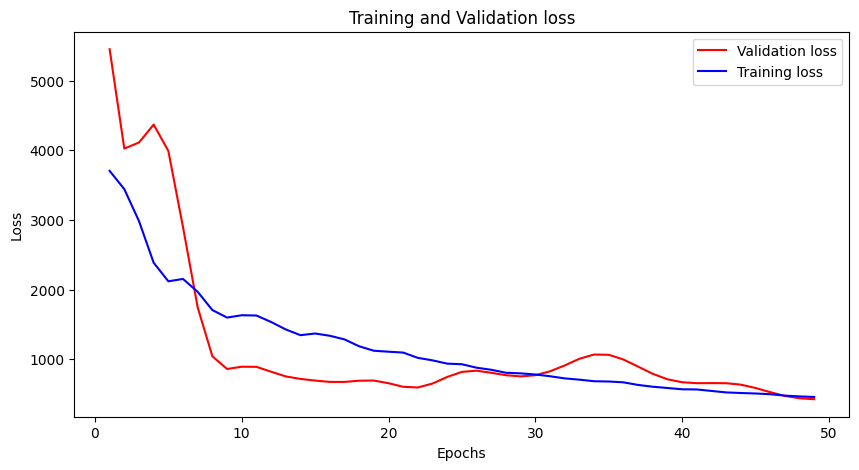

MSE: 424.9715576171875 - RMSE: 20.614837646484375 - MAE: 12.630520820617676


In [32]:
plot_loss(history)
evaluate_model(model_g, X_g_test, y_g_test, y_g_scaler)

In [33]:
# save model
torch.save(model_g, f'{models_folder}/general.pt')

## Single Thread

In [34]:
input_dim = len(features_st)
# hyperparameters
if study_st is not None:
	num_heads = study_st.best_trial.params['num_heads']
	model_dim = study_st.best_trial.params['model_dim']
	num_layers = study_st.best_trial.params['num_layers']
	dropout = study_st.best_trial.params['dropout']
	lr = study_st.best_trial.params['learning_rate']
	wd = study_st.best_trial.params['weight_decay']
	num_epochs = study_st.best_trial.params['num_epochs']
else:
	num_heads = 6
	model_dim = 192
	num_layers = 4
	dropout = 0.3731512093597947
	lr = 0.0027591245533166004
	wd = 0.0014100590768903643
	num_epochs = 78

In [35]:
# single thread model initialization
model_st = TransformerModel(input_dim, model_dim, num_heads, num_layers, 1, dropout)
if DEVICE.type == 'cuda':
	model_st = model_st.to(DEVICE)
criterion_st = nn.MSELoss()
optimizer_st = optim.AdamW(model_st.parameters(), lr=lr, weight_decay=wd)

history = {
	'loss': [],
	'val_loss': []
}

y_train_inv_scaled = inv_scaling(y_st_train, y_st_scaler)
y_test_inv_scaled = inv_scaling(y_st_test, y_st_scaler)
model_st.train()
for epoch in range(num_epochs):
	optimizer_st.zero_grad()
	output = model_st(X_st_train)
	loss = criterion_st(output, y_st_train)
	loss.backward()
	optimizer_st.step()
	# validation
	model_st.eval()
	output_inv_scaled = inv_scaling(output, y_st_scaler, True)
	loss_inv_scaled = mean_squared_error(y_train_inv_scaled, output_inv_scaled)
	with torch.no_grad():
		predictions = model_st(X_st_test)
		val_loss = criterion_st(predictions, y_st_test)

		predictions_inv_scaled = inv_scaling(predictions, y_st_scaler)
		val_loss_inv_scaled = mean_squared_error(y_test_inv_scaled, predictions_inv_scaled)
		history['loss'].append(loss_inv_scaled.item())
		history['val_loss'].append(val_loss_inv_scaled.item())
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_inv_scaled.item()}, Val Loss: {val_loss_inv_scaled.item()}')
	model_st.train()

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/37, Loss: 8557.865234375, Val Loss: 13979.7138671875
Epoch 2/37, Loss: 24759.712890625, Val Loss: 2704.58056640625
Epoch 3/37, Loss: 6386.5126953125, Val Loss: 4660.21826171875
Epoch 4/37, Loss: 2403.241943359375, Val Loss: 13264.2041015625
Epoch 5/37, Loss: 9697.4248046875, Val Loss: 10484.1396484375
Epoch 6/37, Loss: 8538.3564453125, Val Loss: 3275.246337890625
Epoch 7/37, Loss: 2859.981689453125, Val Loss: 865.08740234375
Epoch 8/37, Loss: 1135.530029296875, Val Loss: 3480.432373046875
Epoch 9/37, Loss: 3646.691162109375, Val Loss: 5641.935546875
Epoch 10/37, Loss: 5577.90869140625, Val Loss: 4562.2392578125
Epoch 11/37, Loss: 4463.4951171875, Val Loss: 1993.30126953125
Epoch 12/37, Loss: 2021.3173828125, Val Loss: 628.386474609375
Epoch 13/37, Loss: 737.6653442382812, Val Loss: 1285.443603515625
Epoch 14/37, Loss: 1305.6549072265625, Val Loss: 2713.059326171875
Epoch 15/37, Loss: 2523.4169921875, Val Loss: 3310.452880859375
Epoch 16/37, Loss: 2805.737060546875, Val Loss: 26

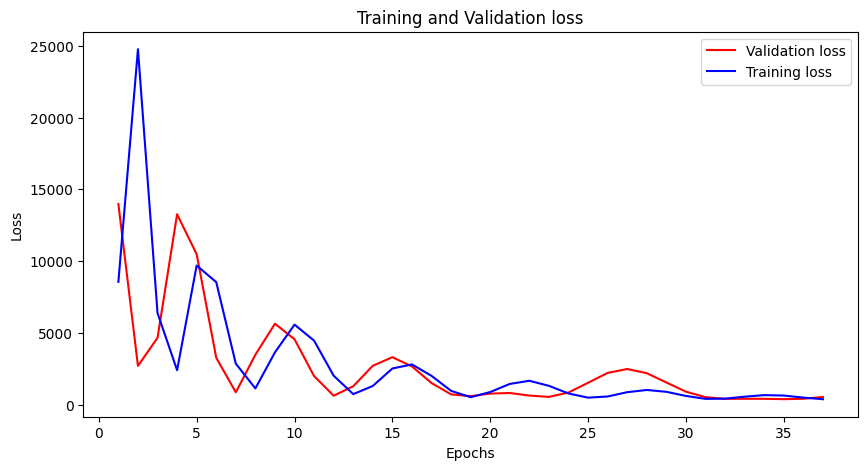

MSE: 538.2899169921875 - RMSE: 23.20107650756836 - MAE: 13.797404289245605


In [36]:
plot_loss(history)
evaluate_model(model_st, X_st_test, y_st_test, y_st_scaler)

In [37]:
# save model
torch.save(model_st, f'{models_folder}/single_thread.pt')

## Multi Thread

In [38]:
input_dim = len(features)
# hyperparameters
if study_mm is not None:
	num_heads = study_mm.best_trial.params['num_heads']
	model_dim = study_mm.best_trial.params['model_dim']
	num_layers = study_mm.best_trial.params['num_layers']
	dropout = study_mm.best_trial.params['dropout']
	lr = study_mm.best_trial.params['learning_rate']
	wd = study_mm.best_trial.params['weight_decay']
	num_epochs = study_mm.best_trial.params['num_epochs']
else:
	num_heads = 7
	model_dim = 413
	num_layers = 1
	dropout = 0.2897232837483553
	lr = 0.0016919131094273875
	wd = 0.0008901136789000729
	num_epochs = 49

In [39]:
# multi thread model initialization
model_mm = TransformerModel(input_dim, model_dim, num_heads, num_layers, 1, dropout)
if DEVICE.type == 'cuda':
	model_mm = model_mm.to(DEVICE)
criterion_mm = nn.MSELoss()
optimizer_mm = optim.AdamW(model_mm.parameters(), lr=lr, weight_decay=wd)

history = {
	'loss': [],
	'val_loss': []
}

y_train_inv_scaled = inv_scaling(y_mm_train, y_mm_scaler)
y_test_inv_scaled = inv_scaling(y_mm_test, y_mm_scaler)
model_mm.train()
for epoch in range(num_epochs):
	optimizer_mm.zero_grad()
	output = model_mm(X_mm_train)
	loss = criterion_mm(output, y_mm_train)
	loss.backward()
	optimizer_mm.step()
	# validation
	model_mm.eval()
	output_inv_scaled = inv_scaling(output, y_mm_scaler, True)
	loss_inv_scaled = mean_squared_error(y_train_inv_scaled, output_inv_scaled)
	with torch.no_grad():
		predictions = model_mm(X_mm_test)
		val_loss = criterion_mm(predictions, y_mm_test)

		predictions_inv_scaled = inv_scaling(predictions, y_mm_scaler)
		val_loss_inv_scaled = mean_squared_error(y_test_inv_scaled, predictions_inv_scaled)
		history['loss'].append(loss_inv_scaled.item())
		history['val_loss'].append(val_loss_inv_scaled.item())
	print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss_inv_scaled.item()}, Val Loss: {val_loss_inv_scaled.item()}')
	model_mm.train()

Epoch 1/24, Loss: 3145.40234375, Val Loss: 99020.9375
Epoch 2/24, Loss: 107144.3671875, Val Loss: 13123.1494140625
Epoch 3/24, Loss: 20209.16796875, Val Loss: 5859.9833984375
Epoch 4/24, Loss: 1619.3367919921875, Val Loss: 26425.3515625
Epoch 5/24, Loss: 15136.9248046875, Val Loss: 24876.923828125
Epoch 6/24, Loss: 15956.0498046875, Val Loss: 13246.8837890625
Epoch 7/24, Loss: 8639.2626953125, Val Loss: 3398.734619140625
Epoch 8/24, Loss: 2094.430908203125, Val Loss: 16.1539249420166
Epoch 9/24, Loss: 230.30601501464844, Val Loss: 2144.484375
Epoch 10/24, Loss: 2619.02001953125, Val Loss: 4516.85009765625
Epoch 11/24, Loss: 4992.67041015625, Val Loss: 4483.458984375
Epoch 12/24, Loss: 5063.5576171875, Val Loss: 2830.33984375
Epoch 13/24, Loss: 3452.9287109375, Val Loss: 1031.3399658203125
Epoch 14/24, Loss: 1589.211181640625, Val Loss: 73.44114685058594
Epoch 15/24, Loss: 396.2097473144531, Val Loss: 260.1053771972656
Epoch 16/24, Loss: 171.23304748535156, Val Loss: 1274.734130859375
E

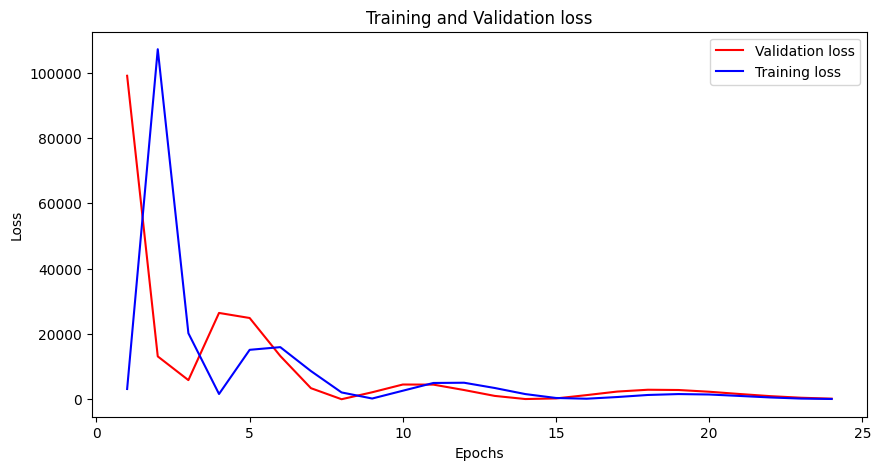

MSE: 185.51397705078125 - RMSE: 13.620351791381836 - MAE: 13.199342727661133


In [40]:
plot_loss(history)
evaluate_model(model_mm, X_mm_test, y_mm_test, y_mm_scaler)

In [41]:
# save model
torch.save(model_mm, f'{models_folder}/multi_thread.pt')

# Load models

In [42]:
model_g = torch.load(f'{models_folder}/general.pt').to(DEVICE)
model_st = torch.load(f'{models_folder}/single_thread.pt').to(DEVICE)
model_mm = torch.load(f'{models_folder}/multi_thread.pt').to(DEVICE)

In [43]:
# 1 instance prediction
def predict(model, X):
	model.eval()
	with torch.no_grad():
		prediction = model(X)
	return prediction

def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}
	
	predictions = predict(model, X)
	predictions = inv_scaling(predictions, y_scaler)
	y_scaled = inv_scaling(y, y_scaler)
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [44]:
# general model
print("Validation set general model")
min_instance, max_instance, predictions = describe_val(model_g, X_g_test, y_g_test, y_g_scaler)
y_scaled = inv_scaling(y_g_test, y_g_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("---")
print("Min instance")
print(g_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(g_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set general model
Mean prediction: 25.401153564453125 | Std actual: 13.840083122253418
Mean actual: 35.04148483276367 | Std actual: 28.83706283569336
Mean Error: 12.630520820617676 | Std Error: 16.292375564575195
---
Min instance
total_time                                                            21.6
total_cpu_usage                                                       0.99
max_ram_usage                                                    10.207031
brand_raw                         Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
count                                                                   56
l2_cache_size                                                         70.0
l3_cache_size                                                         42.0
l2_cache_line_size                                                     256
l2_cache_associativity                                                   6
benchmark                                                         N_Queens
ghz_actua

In [45]:
# single thread model
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model_st, X_st_test, y_st_test, y_st_scaler)
y_scaled = inv_scaling(y_st_test, y_st_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(st_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(st_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 21.995832443237305 | Std actual: 13.45119857788086
Mean actual: 34.75261306762695 | Std actual: 31.49396324157715
Mean Error: 13.797404289245605 | Std Error: 18.65265655517578
Min instance
total_time                                                           17.91
total_cpu_usage                                                       0.99
max_ram_usage                                                  1435.503906
brand_raw                         Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz
count                                                                    8
l2_cache_size                                                          1.0
l3_cache_size                                                          8.0
l2_cache_line_size                                                     256
l2_cache_associativity                                                   6
benchmark                                                              KNP
ghz_actua

In [46]:
# multi thread model
print("Validation set multi thread model")
min_instance, max_instance, predictions = describe_val(model_mm, X_mm_test, y_mm_test, y_mm_scaler)
y_scaled = inv_scaling(y_mm_test, y_mm_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(mm_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(mm_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set multi thread model
Mean prediction: 23.33465576171875 | Std actual: 3.2491378784179688
Mean actual: 36.53400421142578 | Std actual: 0.8569860458374023
Mean Error: 13.199342727661133 | Std Error: 3.3602561950683594
Min instance
total_time                                                                 25.97
total_cpu_usage                                                              6.8
max_ram_usage                                                         2352.96875
brand_raw                         11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
count                                                                          8
l2_cache_size                                                                5.0
l3_cache_size                                                                8.0
l2_cache_line_size                                                           256
l2_cache_associativity                                                         7
benchmark                    